In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import os
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

# datos

**usarios con Ansiedad** = 1
**usarios con Control** = 0

**PREPARACIÓN DE DATOS**

*Cargar y limpiar*

In [ ]:
!pip install pyspellchecker
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.3 MB/s eta 0:00:00
2023-11-19 04:39:53.220392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 04:39:53.220488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 04:39:53.220538: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 04:39:55.420146: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 65.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.

# limpiar texto y Crear Tokens

In [ ]:
import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def load_doc(filename):
    try:
        data = pd.read_csv(filename, delimiter='\t')  # Indicamos el delimitador como '\t' para TSV
        return data
    except Exception as e:
        print("Error:", e)
        return None

#Creamos un función de limpieza del texto y  los guarde en tokens indivicuales o lista de palabras
def clean_doc(text):
    # Eliminar hashtags
    text = re.sub(r'#\w+', '', text)

    # Eliminar URLs o enlaces
    text = re.sub(r'(https?://)?[a-zA-Z0-9]+\.[a-zA-Z0-9]+\S*', '', text)

    # Eliminar nombres de usuarios de Twitter
    text = re.sub(r'@\w+', '', text)

    # Eliminar Nombres propios
    text = re.sub(r'\b[A-Z][a-z]+\b', '', text)

    # Eliminar todos los caracteres especiales
    text = re.sub(r'[^\w\s]+', '', text)

    # Eliminar prefijos y números
    text = re.sub(r'\b\w{1,2}\b|\d+', '', text)

    # Eliminar palabras específicas
    specific_words = ['retweet', 'retweets', 'hashtag', 'trending', 'mención', 'enlace', 'emoji', 'timeline', 'interacciones',
                      'tuit', 'seguidores', 'notificaciones', 'seguir', 'favorito', 'perfil', 'tendencia', 'influencer',
                      'compartir', 'actualización', 'explorar', 'seguir', 'comunidad', 'contenido', 'popular',
                      'recomendar', 'experiencia', 'conectar', 'comentar', 'compartir', 'comunidad', 'actualización',
                      'drk', 'followers', 'stats', 'for', 'new', 'little', 'unfollower', 'unfollowers', 'today', 'shit','twitter','nombre',
                      'eric','story','great', 'short','squeeze','piggly','wiggly','hmv','even','follas','you','i','he','she',
                      'it','we','they','the','and','that','these','those','tweet','followed','follower']
    text = ' '.join([word for word in text.split() if word not in specific_words])

    # Eliminar emojis
    emojis = re.findall(r'[^\w\s,]', text)
    cleaned_emojis = [emoji for emoji in emojis if emoji not in ['@', '#', '/', '?','¿','.','…','"',':','“','!','¡','°','-',"‘",'’',
                                                                 '=',';','(',')',"'","'",'&','€','%','$','*','+','|', '”','🇦','🇷',',',
                                                                 ', ','—','«',' »','»','« ','[, ]','[,]',',',', ','',' ',' ♀',' 🏽']]
    for emoji in cleaned_emojis:
        text = text.replace(emoji, '')

    # Convertir el texto a minúsculas
    text = text.lower()

    return text

def removeHTML(text):
    if isinstance(text, str):  # Verificar si es de tipo string
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', text)
        return cleantext
    else:
        return text  # Devolver el valor original si no es de tipo string


In [ ]:
def cargar_documentos(ruta, etiqueta):
    documentos = []
    etiquetas = []

    for archivo in os.listdir(ruta):
        if archivo.endswith(".csv"):
            # Leer el archivo CSV usando pandas
            df = pd.read_csv(os.path.join(ruta, archivo))

            # Verificar si la columna "tweet" existe en el DataFrame
            if 'tweet' in df.columns:
                # Obtener solo la columna "tweet"
                tweets = df['tweet'].tolist()

                # Agregar los tweets y etiquetas a las listas
                documentos.extend(tweets)
                etiquetas.extend([etiqueta] * len(tweets))

    return documentos, etiquetas

In [ ]:
# Rutas de las carpetas
ruta_ans = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usuarios con ansiedad/'
ruta_cont = '/content/drive/MyDrive/Experimentación Python Tesis /Experimento por agrupación de usuarios/Usarios de control 2/'

In [ ]:
# Cargar documentos y etiquetas
Ans, etiquetas_ans = cargar_documentos(ruta_ans, etiqueta=1) # Ansiedad  = 1
Cont, etiquetas_cont = cargar_documentos(ruta_cont, etiqueta=0) # Control = 0


In [ ]:
# Crear un DataFrame usando pandas
data_tweet = pd.DataFrame({'tweets': Ans + Cont, 'trastorno': etiquetas_ans + etiquetas_cont})

In [ ]:
data_tweet['tweets'] = data_tweet['tweets'].astype(str)
data_tweet.info()
data_tweet.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131894 entries, 0 to 131893
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tweets     131894 non-null  object
 1   trastorno  131894 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


,tweets,trastorno
0,@USUARIO JAJAJAJAJA esa es una historia mal co...,1
1,@USUARIO al menos no atrasé a mi causa con su ...,1
2,que sería sino,1
3,me gusta la calle cuando hay gente,1
4,"odio que me manden audios de más de 2min, teng...",1
5,"Icardi no puede jugar en este PSG, no está al ...",1
6,Que bien le hace a Neymar jugar al lado de Mes...,1
7,@USUARIO hermano muchas veces nuestro error es...,1
8,máscara pa los bobos yo te avisé,1
9,@USUARIO Prepara las ideas pal vacunafest,1


In [ ]:
data_tweet['tweets'] = data_tweet['tweets'].apply(removeHTML)
data_tweet['tweets'] = data_tweet['tweets'].apply(clean_doc)
data_tweet

,tweets,trastorno
0,jajajajaja esa una historia mal contada,1
1,menos atrasé causa con flaca,1
2,que sería sino,1
3,gusta calle cuando hay gente,1
4,odio que manden audios más min tengo tdah pued...,1
...,...,...
131889,declaraciones httpurl,0
131890,favoritos,0
131891,dulce espera entre tus caricias tiernas las vi...,0
131892,mamá toc infartan cada que visita,0


# **LIWC**

In [ ]:
!pip install liwc
import liwc

In [ ]:
liwcPath= r'/content/drive/MyDrive/Experimentación Python Tesis /Diccionarios español/Spanish_LIWC2007_Dictionary.dic'
parse, category_names = liwc.load_token_parser(liwcPath)
print(f'Categorias del diccionario: {category_names}')

Categorias del diccionario: ['Funct', 'TotPron', 'PronPer', 'Yo', 'Nosotro', 'TuUtd', 'ElElla', 'Ellos', 'PronImp', 'Articulo', 'Verbos', 'VerbAux', 'Pasado', 'Present', 'Futuro', 'Adverb', 'Prepos', 'Conjunc', 'Negacio', 'Cuantif', 'Numeros', 'Maldec', 'verbYO', 'verbTU', 'verbNOS', 'verbosEL', 'verbELLOS', 'Subjuntiv', 'VosUtds', 'formal', 'informal', 'verbVos', 'Social', 'Familia', 'Amigos', 'Humanos', 'Afect', 'EmoPos', 'EmoNeg', 'Ansiedad', 'Enfado', 'Triste', 'MecCog', 'Insight', 'Causa', 'Discrep', 'Tentat', 'Certeza', 'Inhib', 'Incl', 'Excl', 'Percept', 'Ver', 'Oir', 'Sentir', 'Biolog', 'Cuerpo', 'Salud', 'Sexual', 'Ingerir', 'Relativ', 'Movim', 'Espacio', 'Tiempo', 'Trabajo', 'Logro', 'Placer', 'Hogar', 'Dinero', 'Relig', 'Muerte', 'Asentir', 'NoFluen', 'Relleno']


In [ ]:
corpus = []
words = []

for i in range(0,len(data_tweet)):
    review = re.sub('[^a-zA-Z0-9]',' ',data_tweet['tweets'][i])
    review = review.lower()
    review = review.split()

    review = list(category for token in review for category in parse(token))
    statements = ' '.join(review)
    corpus.append(statements)
    words.append(review)

# **Vectorización a través BOW**

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Crear una instancia de CountVectorizer
count_vect = CountVectorizer()

# Aplicar CountVectorizer al corpus
count_train = count_vect.fit_transform(corpus)

# Convertir la matriz dispersa a un array de numpy
X_array = count_train.toarray()

# Imprimir el tamaño del vocabulario construido por CountVectorizer
print("El tamaño del vocabulario es: ", len(count_vect.vocabulary_))

X = X_array  # Array de numpy
y = data_tweet['trastorno'].values  # Etiquetas de trastorno de la columna 'trastorno'

features = count_vect.get_feature_names_out()

# Crear un DataFrame con la matriz de conteo
df_count = pd.DataFrame(X, columns=features)
df_count

El tamaño del vocabulario es:  73


,adverb,afect,amigos,ansiedad,articulo,asentir,biolog,causa,certeza,conjunc,...,verbaux,verbellos,verbnos,verbos,verbosel,verbtu,verbvos,verbyo,vosutds,yo
0,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,...,0,0,0,3,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,1,0,0,4,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131890,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131891,0,6,0,1,2,0,4,0,2,0,...,0,0,0,5,1,0,0,0,0,1
131892,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X


array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 6, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

# **Dividir los datos de entrenamiento y prueba**

In [ ]:

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

# Verificar las dimensiones después de la división
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_val:", y_val.shape)


Dimensiones de X_train: (92325, 73)
Dimensiones de y_train: (92325,)
Dimensiones de X_val: (39569, 73)
Dimensiones de y_val: (39569,)


In [ ]:
X_train

array([[1, 1, 0, ..., 0, 0, 0],
       [2, 3, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

**Modelo análisis de texto**

#Red neuronal

In [ ]:
# Crear una red neuronal secuencial

model = Sequential()

# Agregar una capa de entrada con el número de características
model.add(Dense(328, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(264, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(164, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización

# Agregar una capa oculta
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))  # Dropout para regularización


# Agregar una capa de salida con una neurona y función de activación sigmoide para clasificación binaria
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo en los datos de entrenamiento
history = model.fit(X_train, y_train, epochs=10, batch_size=50, validation_data=(X_val, y_val))

# Evaluar el modelo en el conjunto de validación
y_val_pred = (model.predict(X_val) > 0.5).astype(int)

# Calcular métricas de evaluación en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcular métricas de evaluación en el conjunto de entrenamiento
y_train_pred = (model.predict(X_train) > 0.5).astype(int)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

Epoch 1/10
1847/1847 [==============================] - 21s 11ms/step - loss: 0.6789 - accuracy: 0.5589 - val_loss: 0.6724 - val_accuracy: 0.5699
Epoch 2/10
1847/1847 [==============================] - 18s 10ms/step - loss: 0.6710 - accuracy: 0.5722 - val_loss: 0.6725 - val_accuracy: 0.5732
Epoch 3/10
1847/1847 [==============================] - 19s 10ms/step - loss: 0.6671 - accuracy: 0.5800 - val_loss: 0.6676 - val_accuracy: 0.5793
Epoch 4/10
1847/1847 [==============================] - 21s 11ms/step - loss: 0.6639 - accuracy: 0.5839 - val_loss: 0.6666 - val_accuracy: 0.5789
Epoch 5/10
1847/1847 [==============================] - 19s 10ms/step - loss: 0.6596 - accuracy: 0.5893 - val_loss: 0.6680 - val_accuracy: 0.5742
Epoch 6/10
1847/1847 [==============================] - 18s 10ms/step - loss: 0.6560 - accuracy: 0.5944 - val_loss: 0.6664 - val_accuracy: 0.5781
Epoch 7/10
1847/1847 [==============================] - 19s 10ms/step - loss: 0.6518 - accuracy: 0.5991 - val_loss: 0.6693 -

In [ ]:
# Imprimir métricas de entrenamiento
print("\nMétricas en el conjunto de entrenamiento:")
print(f"Exactitud (entrenamiento): {round(accuracy_train, 2) * 100}%")
print(f"Precisión (entrenamiento): {round(precision_train, 2) * 100}%")
print(f"Recall (entrenamiento): {round(recall_train, 2) * 100}%")
print(f"F1-score (entrenamiento): {round(f1_train, 2) * 100}%")
print('-------------------------------------------------------------------------')
# Imprimir métricas de evaluación
print(f"Exactitud en el conjunto de validación: {round(accuracy, 2) * 100}%")
print(f"Precisión en el conjunto de validación: {round(precision, 2) * 100}%")
print(f"Recall en el conjunto de validación: {round(recall, 2) * 100}%")
print(f"F1-score en el conjunto de validación: {round(f1, 2) * 100}%")


Métricas en el conjunto de entrenamiento:
Exactitud (entrenamiento): 63.0%
Precisión (entrenamiento): 61.0%
Recall (entrenamiento): 68.0%
F1-score (entrenamiento): 64.0%
-------------------------------------------------------------------------
Exactitud en el conjunto de validación: 57.99999999999999%
Precisión en el conjunto de validación: 56.99999999999999%
Recall en el conjunto de validación: 62.0%
F1-score en el conjunto de validación: 59.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

1237/1237 [==============================] - 4s 3ms/step
Matriz de confusión: 

 [[10798  9181]
 [ 7526 12064]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.54


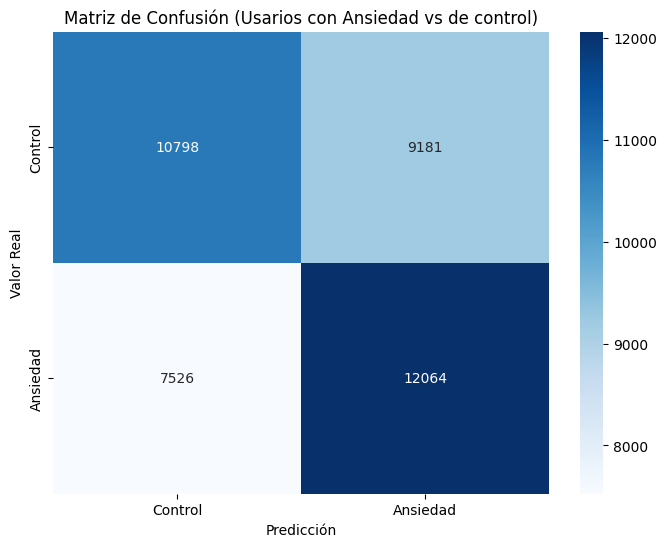

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo Bosque Aleatorio

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Importa las librerías necesarias y divide los datos en conjuntos de entrenamiento y validación
from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val

# Crea un modelo de Random Forest
random_forest_model = RandomForestClassifier(n_estimators=300,  # Numero de alboles
                                             max_depth=100, # profunidad máxima
                                             random_state=42)  # selección de la semilla de manera aleatoria


# Entrena el modelo en los datos de entrenamiento
random_forest_model.fit(X_train, y_train)

# Realiza predicciones en los datos de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcula la precisión (accuracy) del modelo en los datos de validación
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy (validación): {:.2f}".format(accuracy))

# Calcula la precisión del modelo en los datos de validación
precision = precision_score(y_val, y_val_pred)
print("Precision (validación): {:.2f}".format(precision))

# Calcula la exactitud (recall) del modelo en los datos de validación
recall = recall_score(y_val, y_val_pred)
print("Recall (validación): {:.2f}".format(recall))

# Calcula el F1-score del modelo en los datos de validación
f1 = f1_score(y_val, y_val_pred)
print("F1-score (validación): {:.2f}".format(f1))

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = random_forest_model.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

#




Accuracy (validación): 0.57
Precision (validación): 0.57
Recall (validación): 0.52
F1-score (validación): 0.54


In [ ]:
# Imprimir las métricas de entrenamiento
print(f'Accuracy entrenamiento: {accuracy_train * 100:.2f}%')
print(f'Precisión  entrenamiento: {precision_train * 100:.2f}%')
print(f'Recall  entrenamiento: {recall_train * 100:.2f}%')
print(f'Puntuación F1  entrenamiento: {f1_train * 100:.2f}%')
print('\n')
# Imprimir las métricas de validación
print(f'Accuracy  validación: {accuracy * 100:.2f}%')
print(f'Precisión  validación: {precision* 100:.2f}%')
print(f'Recall  validación: {recall* 100:.2f}%')
print(f'Puntuación F1 validación: {f1 * 100:.2f}%')

Accuracy entrenamiento: 88.73%
Precisión  entrenamiento: 90.74%
Recall  entrenamiento: 85.79%
Puntuación F1  entrenamiento: 88.20%


Accuracy  validación: 57.02%
Precisión  validación: 57.31%
Recall  validación: 51.72%
Puntuación F1 validación: 54.37%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = random_forest_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[12432  7547]
 [ 9459 10131]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.45


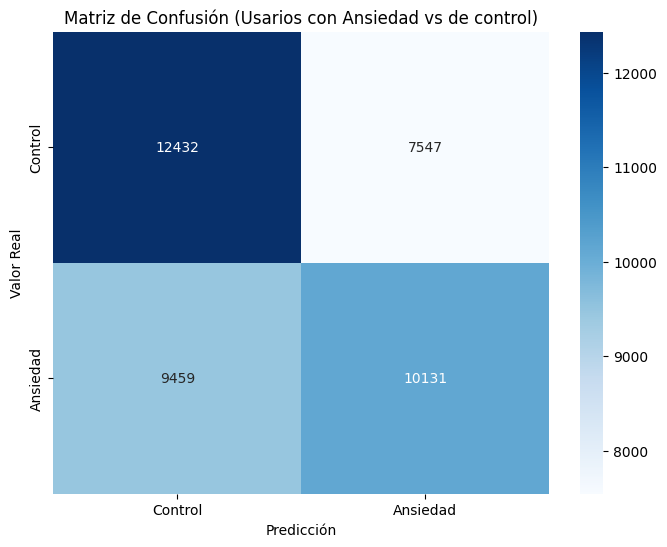

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

#Modelo SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import os

svm_model_p = SVC(kernel='poly', degree=4, C=50000,  max_iter=10000, probability=False, gamma='scale', coef0=2.5)

# Entrenar el modelo en los datos de entrenamiento
svm_model_p.fit(X_train, y_train)

# Predecir etiquetas en el conjunto de validación
y_val_pred = svm_model_p.predict(X_val)

# Calcula la precisión del modelo en el conjunto de validación
accuracy = accuracy_score(y_val, y_val_pred)


# Calcula precisión, exhaustividad y puntuación F1 en el conjunto de validación
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

# Calcula y muestra métricas en el conjunto de entrenamiento
y_train_pred = svm_model_p.predict(X_train)

accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred)

print("\nEntrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train*100))
print("Precision (entrenamiento): {:.2f}%".format(precision_train*100))
print("Recall (entrenamiento): {:.2f}%".format(recall_train*100))
print("F1-score (entrenamiento): {:.2f}%".format(f1_train*100))
print("\nValidación:")
print(f"Exactitud en el conjunto de validación: {round(accuracy,2)*100}%")
print(f"Precisión en el conjunto de validación:{round(precision,2)*100}%")
print(f"Recall en el conjunto de validación: {round(recall,2)*100}%")
print(f"F1-score en el conjunto de validación:{round(f1,2)*100}%")



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Entrenamiento:
Exactitud (entrenamiento): 50.26%
Precision (entrenamiento): 49.64%
Recall (entrenamiento): 92.12%
F1-score (entrenamiento): 64.51%

Validación:
Exactitud en el conjunto de validación: 51.0%
Precisión en el conjunto de validación:50.0%
Recall en el conjunto de validación: 92.0%
F1-score en el conjunto de validación:65.0%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = svm_model_p.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[ 1909 18070]
 [ 1503 18087]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.91


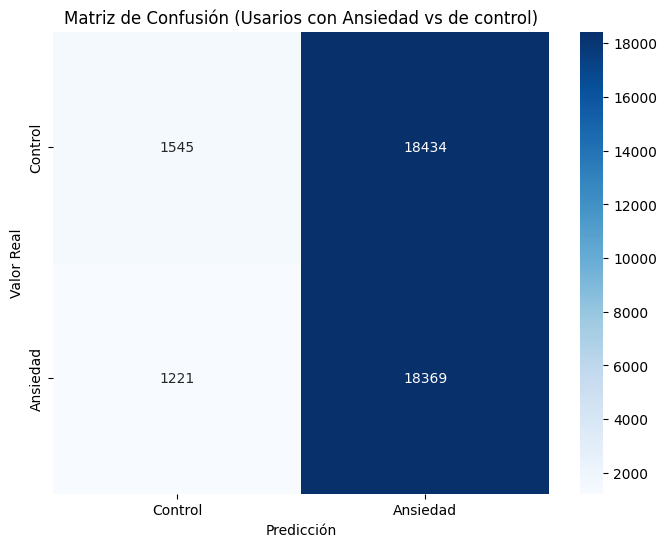

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()

# **Regresión Logistica**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
# Crear el modelo de regresión logística
lr_model = LogisticRegression(C=100)
lr_model.fit(X_train, y_train)

# Calcular el porcentaje de acierto en el conjunto de entrenamiento
accuracy_train = lr_model.score(X_train, y_train) * 100

# Calcular el porcentaje de acierto en el conjunto de validación
accuracy_val = lr_model.score(X_val, y_val) * 100

# Predicciones en el conjunto de entrenamiento y validación
y_train_pred = lr_model.predict(X_train)
y_val_pred = lr_model.predict(X_val)

# Calcular precisión en el conjunto de entrenamiento y validación
precision_train = precision_score(y_train, y_train_pred)* 100
precision_val = precision_score(y_val, y_val_pred)* 100

# Calcular exhaustividad (recall) en el conjunto de entrenamiento y validación
recall_train = recall_score(y_train, y_train_pred)* 100
recall_val = recall_score(y_val, y_val_pred)* 100

# Calcular puntuación F1 en el conjunto de entrenamiento y validación
f1_train = f1_score(y_train, y_train_pred)* 100
f1_val = f1_score(y_val, y_val_pred)* 100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Mostrar métricas de entrenamiento
print("Métricas de entrenamiento:")
print("Exactitud (entrenamiento): {:.2f}%".format(accuracy_train))
print("Precisión (entrenamiento): {:.2f}%".format(precision_train))
print("Exhaustividad (entrenamiento): {:.2f}%".format(recall_train))
print("Puntuación F1 (entrenamiento): {:.2f}%".format(f1_train))
print('-'*40)
# Mostrar métricas de validación
print("\nMétricas de validación:")
print("Exactitud (validación): {:.2f}%".format(accuracy_val))
print("Precisión (validación): {:.2f}%".format(precision_val))
print("Exhaustividad (validación): {:.2f}%".format(recall_val))
print("Puntuación F1 (validación): {:.2f}%".format(f1_val))

Métricas de entrenamiento:
Exactitud (entrenamiento): 57.00%
Precisión (entrenamiento): 55.74%
Exhaustividad (entrenamiento): 60.21%
Puntuación F1 (entrenamiento): 57.89%
----------------------------------------

Métricas de validación:
Exactitud (validación): 56.98%
Precisión (validación): 56.13%
Exhaustividad (validación): 59.96%
Puntuación F1 (validación): 57.98%


# **Matriz de confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RF = lr_model.predict(X_val)

# Obtiene la matriz de confusión. Las filas corresponden a las clases reales,
umbral = 0.5  # Puedes ajustar este umbral según tus necesidades
y_pred_binario = (y_pred_RF > umbral).astype(int)

# Calcular la matriz de confusión con las etiquetas binarias
cm = confusion_matrix(y_val, y_pred_binario)
prop_real = np.sum(y_val)/len(y_val)
prop_etiqutados = (cm[0,1]+cm[1,1])/len(y_val)

print("Matriz de confusión: \n\n", cm, "\n")
print('Proporción de comentarios positivos: %.2f'% prop_real)
print('Proporción de comentarios positivos etiquetados: %.2f'% prop_etiqutados)

Matriz de confusión: 

 [[10800  9179]
 [ 7844 11746]] 

Proporción de comentarios positivos: 0.50
Proporción de comentarios positivos etiquetados: 0.53


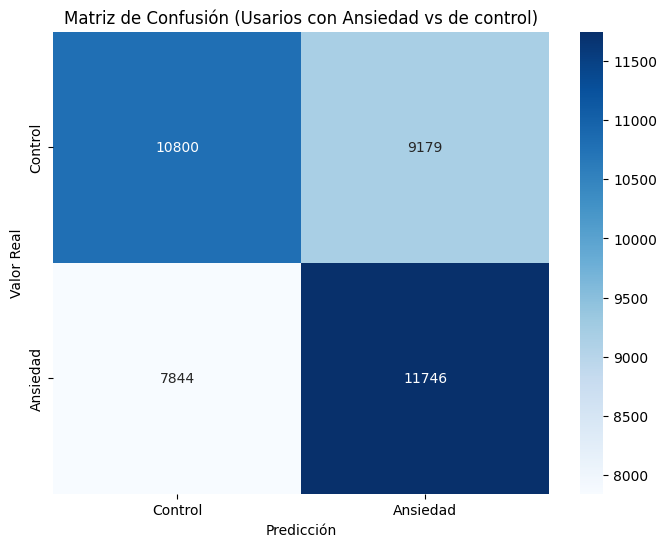

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una figura para la matriz de confusión
plt.figure(figsize=(8, 6))

# Crear una matriz de confusión usando el heatmap de Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'Ansiedad'], yticklabels=['Control', 'Ansiedad'])

# Etiquetas y título
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión (Usarios con Ansiedad vs de control)')

# Mostrar la gráfica
plt.show()